## Exercícios PSO

Leia o artigo de Kennedy & Eberhart.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pylab import rcParams
import pandas as pd
from tqdm import tqdm

def HolderTable(x):
    x_ = x[0]
    y_ = x[1]

    return -abs(np.sin(x_) * np.cos(y_) * np.exp(abs(1 - np.sqrt(x_ * x_ + y_ * y_) / np.pi)))


def funcPaper95(x):
    x1 = x[0]
    x2 = x[1]

    return (x1 - 100.0) ** 2 + (x2 - 100.0) ** 2


# Classe para particula
# Por: Gerson de Souza Faria
class Particula:

    def __init__(self, x0, fronteiras):

        # número de dimensoes do problema
        self.dimensoes = len(x0)

        # posição inicial da partícula
        self.posicao = np.array(x0)

        # fronteiras da partícula [[x1min,y1max]...[xnmin,xnmax]] # n = dimensoes
        self.fronteiras = np.array(fronteiras)

        # velocidade inicial da partícula
        self.velocidade = 2. * np.random.rand(self.dimensoes) - 1.

        # melhor posição da partícula
        self.melhorPosicao = np.zeros(self.dimensoes)

        # melhor valor
        self.melhorValor = -np.Inf

        # erro corrente
        self.valor = -np.Inf

        # avalia o fitness corrente

    def avalia(self, funcaoCusto):
        self.valor = funcaoCusto(self.posicao)

        # verifica se a posição corrente é a melhor até agora

        if self.valor < self.melhorValor or np.isinf(self.melhorValor):
            self.melhorPosicao = self.posicao
            self.melhorValor = self.valor

    # atualiza a velocidade da partícula com base na melhor posição do grupo
    def atualizaVelocidade(self, melhorPosicaoGlobal, w, c1, c2):

        r1 = np.random.rand(self.dimensoes)  # ~U[0, 1)
        r2 = np.random.rand(self.dimensoes)  # ~U[0, 1)

        velocidadeIndividual = c1 * r1 * (self.melhorPosicao - self.posicao)
        velocidadeGrupo = c2 * r2 * (melhorPosicaoGlobal - self.posicao)

        self.velocidade = w * self.velocidade + velocidadeIndividual + velocidadeGrupo

    # atualiza a posição da partícula basedo na nova velocidade
    def atualizaPosicao(self):
        self.posicao = self.posicao + self.velocidade  # há uma constante de tempo 1 implícita aqui...

        # ajusta fronteiras da partícula

        # mínimo
        iMin = self.posicao < self.fronteiras[:, 0]
        self.posicao[iMin] = self.fronteiras[iMin, 0]

        # máximo
        iMax = self.posicao > self.fronteiras[:, 1]
        self.posicao[iMax] = self.fronteiras[iMax, 1]

    def getPosicao(self):
        return self.posicao


# Classe para otimizador
# Por: Gerson de Souza Faria
class PSO():

    def __init__(self, funcaoCusto, x0, fronteiras, opcoes, epsilon, earlyStopFlag, dict_dinamica_particula):
        self.epsilon = epsilon
        self.earlyStopFlag = earlyStopFlag
        self.funcaoCusto = funcaoCusto
        self.x0 = x0
        self.fronteiras = fronteiras

        self.w = dict_dinamica_particula['w']
        self.c1 = dict_dinamica_particula['c1']
        self.c2 = dict_dinamica_particula['c2']

        self.variaveis = {'verbose': False, \
                          'isMovie': False, \
                          'numParticulas': 50, \
                          'maxIteracoes': 100 \
                          }

        for key in self.variaveis:
            if key in opcoes:
                self.variaveis[key] = opcoes[key]

        self.melhorValorGlobal = -np.Inf  # melhor valor do grupo
        self.listaMelhorValorGlobal = []
        self.melhorPosicaoGlobal = []  # melhor posição do grupo
        self.listDerivadaMelhorValorGlobal = []
        self.checkDerivada = 100
        self.iterations = None

        self.numDimensoes = len(x0)

        # cria o enxame

        numParticulas = self.variaveis['numParticulas']

        self.enxame = []

        for i in range(0, numParticulas):
            self.enxame.append(Particula(x0, fronteiras))

        self.numParticulas = self.variaveis['numParticulas']

        self.maxIteracoes = self.variaveis['maxIteracoes']

        self.verbose = self.variaveis['verbose']

        self.isMovie = self.variaveis['isMovie']

    def getMelhorPosicaoGlobal(self):

        return self.melhorPosicaoGlobal

    def updateListaMelhorValorGlobal(self):

        return self.listaMelhorValorGlobal.append(self.melhorValorGlobal)

    def derivadaMelhorValorGlobal(self):
        if len(self.listaMelhorValorGlobal) > 2:
            diff = self.listaMelhorValorGlobal[len(self.listaMelhorValorGlobal)-1] - self.listaMelhorValorGlobal[len(self.listaMelhorValorGlobal)-2]
            return 0 - diff
        else:
            return 100

    def run(self):

        # inicia o loop de otimização

        i = 0

        if self.isMovie:
            self.maxIteracoes = 1
            self.verbose = False


        if earlyStopFlag == 'max_ite':

            while i < self.maxIteracoes:

                if self.verbose:
                    self.iterations = i
                    # print('iteracao: %-4d melhor solução: %e' % (i, self.melhorValorGlobal))

                # varre o enxame e avalia o fitness de cada partícula
                for j in range(self.numParticulas):

                    self.enxame[j].avalia(self.funcaoCusto)

                    # verifica se a partícula j é a melhor global
                    if self.enxame[j].valor < self.melhorValorGlobal or np.isinf(self.melhorValorGlobal):
                        self.melhorPosicaoGlobal = self.enxame[j].posicao
                        self.melhorValorGlobal = self.enxame[j].valor

                        self.updateListaMelhorValorGlobal()
                        self.checkDerivada = self.derivadaMelhorValorGlobal()

                # varre o enxame e atualiza velocidades e posições
                for j in range(self.numParticulas):
                    self.enxame[j].atualizaVelocidade(self.melhorPosicaoGlobal, self.w, self.c1, self.c2)
                    self.enxame[j].atualizaPosicao()

                i += 1
        elif earlyStopFlag == 'simple_diff':
            while self.checkDerivada > self.epsilon:

                if self.verbose:
                    self.iterations = i
                    # print('iteracao: %-4d melhor solução: %e' % (i, self.melhorValorGlobal))

                # varre o enxame e avalia o fitness de cada partícula
                for j in range(self.numParticulas):

                    self.enxame[j].avalia(self.funcaoCusto)

                    # verifica se a partícula j é a melhor global
                    if self.enxame[j].valor < self.melhorValorGlobal or np.isinf(self.melhorValorGlobal):
                        self.melhorPosicaoGlobal = self.enxame[j].posicao
                        self.melhorValorGlobal = self.enxame[j].valor

                        self.updateListaMelhorValorGlobal()
                        self.checkDerivada = self.derivadaMelhorValorGlobal()

                # varre o enxame e atualiza velocidades e posições
                for j in range(self.numParticulas):
                    self.enxame[j].atualizaVelocidade(self.melhorPosicaoGlobal, self.w, self.c1, self.c2)
                    self.enxame[j].atualizaPosicao()

                i += 1

        if not self.isMovie:
            pass
            # resultado final
            # print('\nSolução final:')
            # print('melhorPosicaoGlobal:', self.melhorPosicaoGlobal)
            # print('melhorValorGlobal:', self.melhorValorGlobal)



In [3]:
# Setup inicial
fronteiras = [(0, 150), (0, 150)]  # domínio de busca [(x1_min,x1_max),(x2_min,x2_max)...]

posicao_inicial = [0., 0.]  # posição inicial de todas as partículas

opcoes = {"verbose": True,
          "numParticulas": 50}
epsilon = 0.01

w = .5  # (.5) constante de inercia (peso da velocidade atual)
c1 = 2.  # (2.) constante individual
c2 = 2.  # (2.) constante grupal
dict_dinamica_particula = {'w': w, 'c1': c1, 'c2': c2}

def main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag, function, dict_dinamica_particula, n_loop):
    iter_list = []
    melhor_posicao_global_list = []
    melhor_valor_global_list = []
    for n in tqdm(range(0, n_loop)):
        pso = PSO(function, posicao_inicial, fronteiras, opcoes, epsilon, earlyStopFlag, dict_dinamica_particula)
        output = pso.run()
        iter_list.append(pso.iterations)
        melhor_posicao_global_list.append(pso.melhorPosicaoGlobal)
        melhor_valor_global_list.append(pso.melhorValorGlobal)
    
    return iter_list, melhor_posicao_global_list, melhor_valor_global_list

>**(1)(2pts)** O critério de parada 'numero máximo de iterações' é um limite superior. Implemente um critério de parada melhor. 
>>**(a)** Execute várias vezes o programa para as funções `funcPaper95` e `HolderTable` e veja em quantos passos a convergência para um valor de mínimo usando seu novo critério é atingida. Apresente os resultados obtidos das posições e valores das funções. Para o número de passos, apresente a média e desvio padrão.

In [43]:
# Função "funcPaper95" + metodo de early stopping 'simple_diff
earlyStopFlag = 'simple_diff'
function = funcPaper95

iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                           function, dict_dinamica_particula, n_loop=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.35it/s]


Média 41.7 Desvio Padrão 5.345091205957107


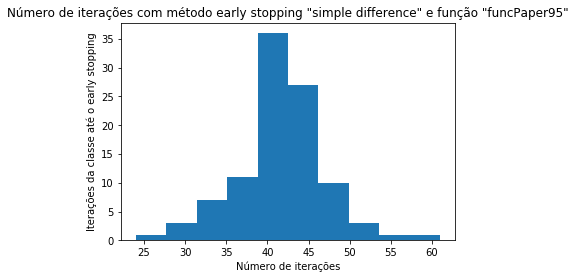

In [44]:
print('Média', np.mean(iter_list), 'Desvio Padrão', np.std(iter_list))
plt.hist(iter_list)
plt.title('Número de iterações com método early stopping "simple difference" e função "funcPaper95"')
plt.xlabel("Número de iterações")
plt.ylabel("Iterações da classe até o early stopping")
plt.show()

Text(0, 0.5, 'Melhor valor global')

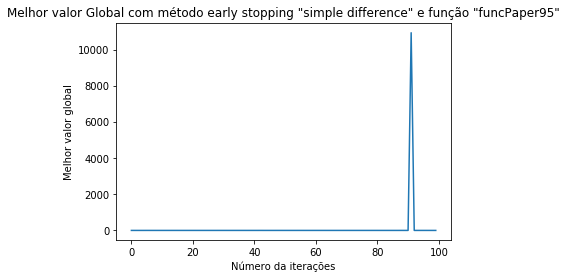

In [29]:
plt.plot(valor_list)
plt.title('Melhor valor Global com método early stopping "simple difference" e função "funcPaper95"')
plt.xlabel("Número da iterações")
plt.ylabel("Melhor valor global")

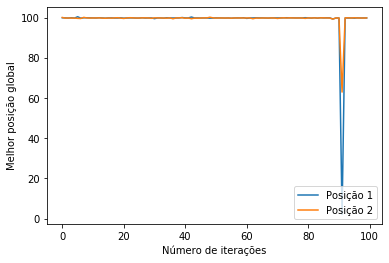

In [31]:
posicao_df = pd.DataFrame(posicao_list)
posicao_df.rename(columns={posicao_df.columns[0]: 'value1', posicao_df.columns[1]: 'value2'}, inplace=True)

fig, ax = plt.subplots()
posicao_df.plot(ax=ax)
plt.xlabel("Número de iterações")
plt.ylabel("Melhor posição global")
ax.legend(['Posição 1', 'Posição 2'], loc='lower right');

In [32]:
# Função "HolderTable" + metodo de early stopping 'simple_diff
earlyStopFlag = 'simple_diff'
function = HolderTable

iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                           function, dict_dinamica_particula, n_loop=100)


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 230.22it/s]


Média 2.89 Desvio Padrão 1.363048054912225


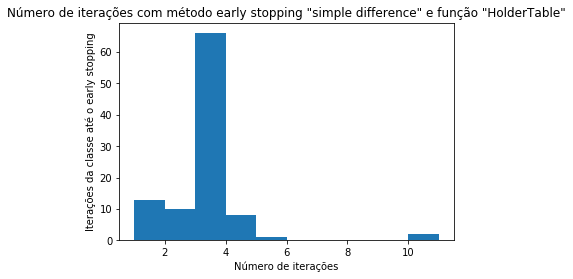

In [34]:
print('Média', np.mean(iter_list), 'Desvio Padrão', np.std(iter_list))
plt.hist(iter_list)
plt.title('Número de iterações com método early stopping "simple difference" e função "HolderTable"')
plt.xlabel("Número de iterações")
plt.ylabel("Iterações da classe até o early stopping")
plt.show()

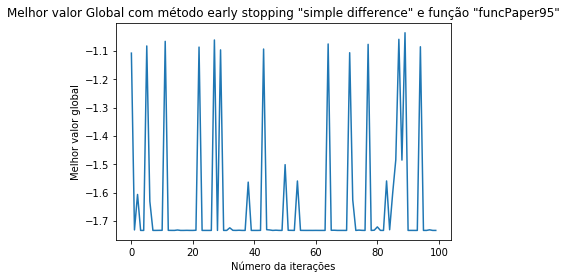

In [35]:
plt.plot(valor_list)
plt.title('Melhor valor Global com método early stopping "simple difference" e função "funcPaper95"')
plt.xlabel("Número da iterações")
plt.ylabel("Melhor valor global")
plt.show()

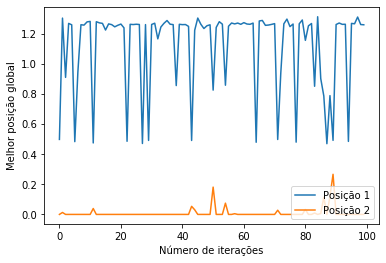

In [36]:
posicao_df = pd.DataFrame(posicao_list)
posicao_df.rename(columns={posicao_df.columns[0]: 'value1', posicao_df.columns[1]: 'value2'}, inplace=True)

fig, ax = plt.subplots()
posicao_df.plot(ax=ax)
plt.xlabel("Número de iterações")
plt.ylabel("Melhor posição global")
ax.legend(['Posição 1', 'Posição 2'], loc='lower right');

>**(2)(1pt)** Nesse programa, todas as partículas tem posição inicial (0,0). Alterar o programa de forma que a posição inicial de cada partícula seja aleatória.
>>**(a)** Refaça o item (1.a). A convergência melhora, *i.e.*, chega no resultado (a menos de um *epsilon*) em menor número de iterações?


In [38]:
earlyStopFlag = 'simple_diff'
function = funcPaper95
posicao_inicial = [np.random.uniform(0, 100), np.random.uniform(0, 100)]

iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                           function, dict_dinamica_particula, n_loop=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.06it/s]


Média 33.66 Desvio Padrão 5.173432129640825


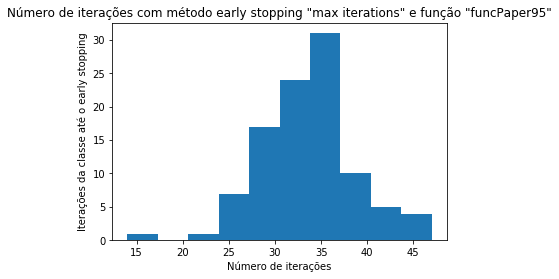

In [39]:
print('Média', np.mean(iter_list), 'Desvio Padrão', np.std(iter_list))
plt.hist(iter_list)
plt.title('Número de iterações com método early stopping "max iterations" e função "funcPaper95"')
plt.xlabel("Número de iterações")
plt.ylabel("Iterações da classe até o early stopping")
plt.show()

In [47]:
earlyStopFlag = 'simple_diff'
function = HolderTable
posicao_inicial = [np.random.random(), np.random.random()]

iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                           function, dict_dinamica_particula, n_loop=100)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.99it/s]


Média 2.26 Desvio Padrão 0.82


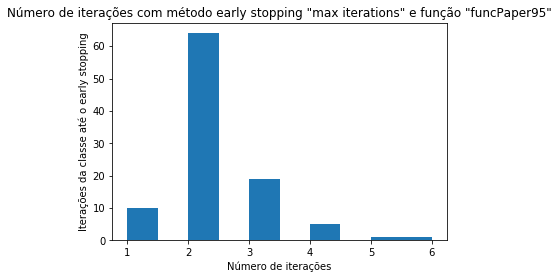

In [48]:
print('Média', np.mean(iter_list), 'Desvio Padrão', np.std(iter_list))
plt.hist(iter_list)
plt.title('Número de iterações com método early stopping "max iterations" e função "funcPaper95"')
plt.xlabel("Número de iterações")
plt.ylabel("Iterações da classe até o early stopping")
plt.show()

>>**(b)** O resultado da otimização permanece o mesmo? Justifique.

**Resposta:** 

Gerar um número aleatório a partir de uma distribuição uniforme com domínio entre 0 e 100 se mostrou ligeiramente melhor. Para a função "funcPaper95" o número médio de iterações se reduz de 41.7 para 33.6, enquanto o desvio padrão fica proxima. Já para a função "HolderTable", o número médio de iterações tem uma redução ligeira de 2.89 para 2.26. Resultados diferentes podem ser sensíveis ao dominio da uniforme que o númedo é gerado.

>**(3)(1pt)** Como o número de partículas altera o resultado do algoritmo? Justifique utilizando gráficos.

In [68]:
earlyStopFlag = 'simple_diff'
function = funcPaper95

output = []
for part in range(100, 500, 10):
    opcoes = {'verbose': True, 'numParticulas': part}
    iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                               function, dict_dinamica_particula, n_loop=1)
    output.append(iter_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


In [70]:
output_df = pd.DataFrame.from_records(output)
new_index = [i for i in range(100, 500, 10)]
output_df.index = new_index

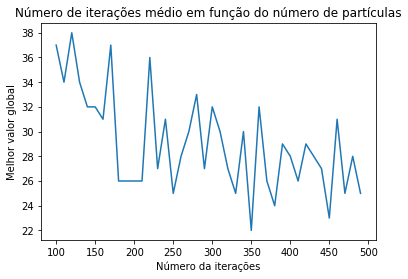

In [71]:
plt.plot(output_df)
plt.title('Número de iterações médio em função do número de partículas')
plt.xlabel("Número de partículas")
plt.ylabel("Número médio de iterações")
plt.show()

**Resposta:** 

A media que o número de particulas aumenta, o número de iterações necessárias para a convergência se reduz.

>**(4)(1pt)** Altere inteligentemente os valores das constantes `w`, `c1` e `c2` em `Particula::atualizaVelocidade`. Essas constantes modificam a dinâmica da partícula e, consequentemente, do enxame. Argumente sobre os resultados obtidos e apresente gráficos que corroborem sua argumentação.


In [4]:
earlyStopFlag = 'simple_diff'
function = funcPaper95
c1 = 2.  # (2.) constante individual
c2 = 2.  # (2.) constante grupal
opcoes = {'verbose': True, 'numParticulas': 50}

# varia constante de inercia
output = []
for w in np.range(.5, 1, .1):
    dict_dinamica_particula = {'w': w, 'c1': c1, 'c2': c2}
    iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                               function, dict_dinamica_particula, n_loop=1)
    output.append(iter_list)
output_df = pd.DataFrame.from_records(output)
new_index = [i for i in np.arange(.5, 1, .1)]
output_df.index = new_index

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


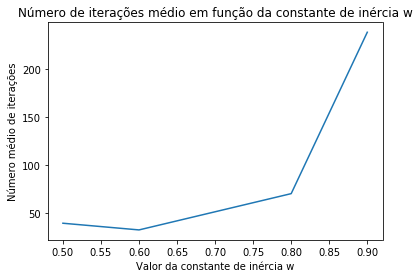

In [5]:
plt.plot(output_df)
plt.title('Número de iterações médio em função da constante de inércia w')
plt.xlabel("Valor da constante de inércia w")
plt.ylabel("Número médio de iterações")
plt.show()

In [7]:
earlyStopFlag = 'simple_diff'
function = funcPaper95
w = .5  # (.5) constante de inercia (peso da velocidade atual)
c2 = 2.  # (2.) constante grupal

# varia constante de individual
output = []
for c1 in np.arange(2, 5, 1):
    dict_dinamica_particula = {'w': w, 'c1': c1, 'c2': c2}
    iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                               function, dict_dinamica_particula, n_loop=1)
    output.append(iter_list)
output_df = pd.DataFrame.from_records(output)
new_index = [i for i in np.arange(2, 5, 1)]
output_df.index = new_index

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


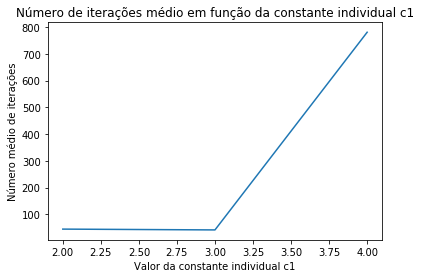

In [8]:
plt.plot(output_df)
plt.title('Número de iterações médio em função da constante individual c1')
plt.xlabel("Valor da constante individual c1")
plt.ylabel("Número médio de iterações")
plt.show()

In [11]:
w = .5  # (.5) constante de inercia (peso da velocidade atual)
c1 = 2.  # (2.) constante individual

# varia constante de grupal
output_particulas = []
for c2 in np.arange(2., 5, 1):
    dict_dinamica_particula = {'w': w, 'c1': c1, 'c2': c2}
    iter_list, posicao_list, valor_list = main(fronteiras, posicao_inicial, opcoes, epsilon, earlyStopFlag,
                                               function, dict_dinamica_particula, n_loop=1)
    output_particulas.append(iter_list)
output_df = pd.DataFrame.from_records(output)
new_index = [i for i in np.arange(2., 5, 1)]
output_df.index = new_index

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


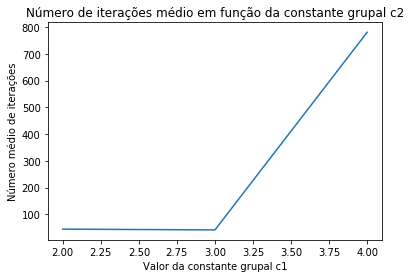

In [12]:
plt.plot(output_df)
plt.title('Número de iterações médio em função da constante grupal c2')
plt.xlabel("Valor da constante grupal c1")
plt.ylabel("Número médio de iterações")
plt.show()

>**(5)** Na sua área de interesse, onde esse algoritmo poderia ser/foi utilizado?

**Resposta**

A técnica apresentada (PSO) pode ser utilizada, por exemplo, na estimação de modelos de curva de juros clássicos como em Nelson-Siegel (1987). Este modelo possui uma representação da curva de juros a partir de uma função paramétrica com 5 parêmetros, o que torna a otimização destes parâmetros razoavelmente complexa. Desta forma, o método PSO poderia ser introduzido para auxiliar na convergência dos parâmetros.